In [1]:
import psycopg2, psycopg2.extensions, psycopg2.extras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

%matplotlib inline

# Uvoz podatkov

Priklopimo se na SQL bazo in naredimo data-preprocessing.

In [2]:
################
#priklop na bazo
psycopg2.extensions.register_type(psycopg2.extensions.UNICODE) # se znebimo problemov s sumniki
baza = psycopg2.connect(database='sem2018_metodj', host='baza.fmf.uni-lj.si', user='metodj', password='gilbertarenas0')
baza.set_isolation_level(psycopg2.extensions.ISOLATION_LEVEL_AUTOCOMMIT) 
cur = baza.cursor(cursor_factory=psycopg2.extras.DictCursor)

################
#test priklopa na bazo
def test(tmp):
    cur.execute('''
                    SELECT * FROM dftest 
                ''', [tmp])
    return (cur.fetchall())

#print(test('')[0])

In [3]:
################
#preprocessing
data = test('')
baza = []
for i in range(len(data)):
    tmp = dict()
    tmp['ime'] = data[i][0]
    tmp['spol'] =  data[i][1]
    tmp['zveznaDržava'] = data[i][2]
    tmp['višina'] = float(data[i][3])
    tmp['plača'] = data[i][4]
    baza.append(tmp)

data = pd.DataFrame(baza)
data['spol'] = np.where(data['spol']=='Male', 'M', 'Ž')
data.head()

,ime,plača,spol,višina,zveznaDržava
0,Montague Goard,3650,M,1.73,TX
1,Danica Di Biaggi,4207,Ž,1.46,SC
2,Patsy Byre,3608,Ž,1.76,NV
3,Tobit Rolling,3490,M,1.74,OR
4,Herculie Dally,2294,M,1.89,MN


Gre za umetno zgenerirane podatke. Za generiranje numeričnih podatkov so bile uporabljene naslednje porazdelitve:

Plača: 1500-4500 (enakomerno porazdeljeno)

Višina: N(1.74, 0.14) (normalno porazdeljeno)

# Laplacov mehanizem za numerične podatke 

Gre za mehanizem iz primera 4.9 

In [185]:
#izracun diametra
def diameter(data):
    return max(data) - min(data)

In [193]:
#nastavi 'plača' ali 'višina'
podatki= list(float(i) for i in data['plača'])
epsilon = 2
delta = 0.5
b = diameter(podatki)/(epsilon - np.log(1-delta))

df_podatki = map(lambda elem: round(elem + np.random.laplace(0,b),2), podatki) #na tem mestu podatkom dodamo Laplacov šum

In [194]:
#osnovna primerjava
print("Diam(D): " + str(diameter(podatki)))
print("Parameter b Laplacove porazdelitve: " + str(b))

rezultat = pd.DataFrame({"podatki": podatki, "zasebni podatki": df_podatki})
rezultat['razlika'] = abs(rezultat["podatki"] - rezultat["zasebni podatki"])
rezultat.head(n=10)

Diam(D): 2996.0
Parameter b Laplacove porazdelitve: 1112.45312608


,podatki,zasebni podatki,razlika
0,3650.0,3212.88,437.12
1,4207.0,4451.85,244.85
2,3608.0,2780.66,827.34
3,3490.0,1623.39,1866.61
4,2294.0,3720.33,1426.33
5,3734.0,2170.02,1563.98
6,2128.0,3000.58,872.58
7,2215.0,4427.01,2212.01
8,3563.0,4641.61,1078.61
9,3921.0,5595.60,1674.60


In [188]:
#poračunanih nekaj osnovnih statistik za primerjavo
print("Povprečje originalni podatki: " + str(sum(podatki)/len(podatki)))
print("Povprečje zasebni podatki: " + str(sum(df_podatki)/len(df_podatki)))
print("Minimum in maximum originalni podatki: " + "(" + str(min(podatki)) + "," + str(max(podatki)) + ")")
print("Minimum in maximum originalni podatki: " + "(" + str(min(df_podatki)) + "," + str(max(df_podatki)) + ")")
print("Povprečna razlika: " + str(rezultat['razlika'].mean()))

Povprečje originalni podatki: 2995.072
Povprečje zasebni podatki: 2993.98731
Minimum in maximum originalni podatki: (1504.0,4500.0)
Minimum in maximum originalni podatki: (894.74,5196.07)
Povprečna razlika: 239.81989


Spodnja meja za največjo napako (izrek 5.3)

In [195]:
spodnja_meja = (1-delta)*diameter(podatki)/(2*(1+np.exp(epsilon)))
print("Spodnja meja za največjo napako iz izreka 5.3: " + str(spodnja_meja))
print("Dejanska največja napaka: " + str(rezultat["razlika"].max()))

Spodnja meja za največjo napako iz izreka 5.3: 89.2829885946
Dejanska največja napaka: 7203.79


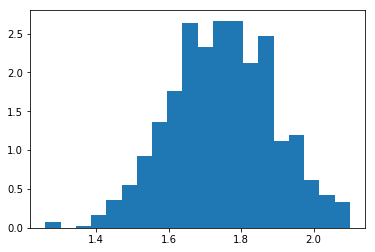

In [111]:
plt.hist(podatki, normed=True, bins=20);

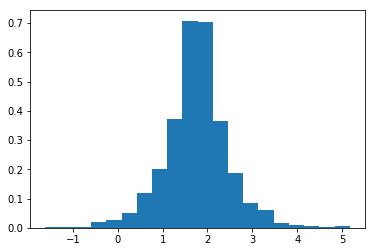

In [112]:
plt.hist(df_podatki, normed=True, bins=20);

# Mehanizem za diskretne podatke

Gre za mehanizem iz primera 4.10

In [80]:
epsilon2 = 7
delta2 = 0.6

In [81]:
#zvezne države

m = 47 # |D| = 48, torej imamo v bazi 48 različnih zveznih držav
p = (1 - delta2) / (m + np.exp(epsilon2))

print("Verjetnost s katero podamo pravi odgovor: " + str(1-p*m))
print("Verjetnost vsakega izmed preostalih m nepravilnih odgovorov: " + str(p))


drzave = list(str(i) for i in data['zveznaDržava'])
seznam_drzav = list(set(drzave))

df_drzave = []
for i in range(len(drzave)):
    if np.random.uniform(0,1) < (1-p*m):
        df_drzave.append(drzave[i])
    else:
        tmp = list(seznam_drzav)
        tmp.remove(drzave[i])
        df_drzave.append(random.choice(tmp))

Verjetnost s katero podamo pravi odgovor: 0.983561162195
Verjetnost vsakega izmed preostalih m nepravilnih odgovorov: 0.000349762506493


In [82]:
#osnovna primerjava
rezultat = pd.DataFrame({"podatki": drzave, "zasebni podatki": df_drzave})
rezultat['ujemanje'] = np.where(rezultat["podatki"] == rezultat["zasebni podatki"], 1 ,0)
rezultat.head(n=10)

,podatki,zasebni podatki,ujemanje
0,TX,TX,1
1,SC,SC,1
2,NV,NV,1
3,OR,OR,1
4,MN,MN,1
5,MO,MO,1
6,WA,WA,1
7,NC,NC,1
8,UT,UT,1
9,MN,MN,1


In [83]:
tmp = []
for state in set(list(rezultat['podatki'])):
    tmp.append((state, list(rezultat['podatki']).count(state)))
    tmp = sorted(tmp, key=lambda x: x[1])
tmp

[('RI', 1),
 ('DE', 2),
 ('WY', 2),
 ('ID', 2),
 ('SD', 2),
 ('ND', 3),
 ('MT', 3),
 ('HI', 4),
 ('NE', 4),
 ('AR', 4),
 ('NM', 5),
 ('MS', 5),
 ('KS', 6),
 ('AK', 7),
 ('CT', 7),
 ('UT', 7),
 ('MA', 8),
 ('OR', 8),
 ('IA', 10),
 ('MD', 10),
 ('WV', 11),
 ('SC', 11),
 ('KY', 11),
 ('NJ', 12),
 ('WI', 13),
 ('WA', 18),
 ('AL', 18),
 ('NV', 19),
 ('OK', 19),
 ('AZ', 19),
 ('MN', 19),
 ('CO', 22),
 ('IN', 22),
 ('TN', 23),
 ('MI', 23),
 ('LA', 24),
 ('MO', 25),
 ('DC', 28),
 ('GA', 28),
 ('IL', 34),
 ('NC', 35),
 ('OH', 35),
 ('VA', 44),
 ('PA', 46),
 ('FL', 62),
 ('NY', 63),
 ('CA', 102),
 ('TX', 114)]

In [84]:
#poračunanih nekaj osnovnih statistik za primerjavo
def most_common(lst):
    return max(set(lst), key=lst.count)

print(most_common(drzave))
print(most_common(df_drzave))

TX
TX


Spodnja meja za največjo napako (izrek 5.4)

In [85]:
spodnja_meja = (1-delta2)*m/(m+np.exp(epsilon2))
spodnja_meja

0.016438837805152762

In [86]:
1000 - sum(rezultat['ujemanje'])

18

In [150]:
#spol (enostaven primer, naš odzivni mehanizem bo kar Bernoullijeva slučanja spremenljivka)

m = 1 # |D| = 2, moški in ženski spol
p = (1 - delta2) / (m + np.exp(epsilon2))

print(p)
print(1-p*m)

0.0237129365888
0.976287063411


In [151]:
spodnja_meja = (1-delta2)*m/(m+np.exp(epsilon2))
spodnja_meja

0.023712936588783391

# Primer funkcijskih podatkov - kernel density estimation

In [88]:
seznam = np.concatenate([np.random.normal(1, 1, [100]), np.random.normal(5, 1, [100])])

C:\Users\Uporabnik\Anaconda2\lib\site-packages\ipykernel\__main__.py:16: RuntimeWarning: covariance is not positive-semidefinite.


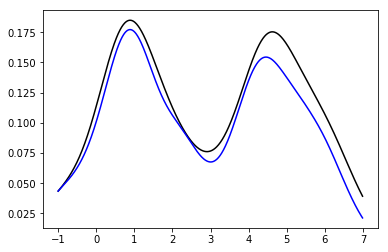

In [102]:
def f(x, h=0.6,d=1):
    return (1/(len(seznam)*(2*np.pi*h**2)**(d*0.5)))*sum(map(lambda elem: np.exp(-((elem-x)**2)/(2*h**2)),seznam))

def koef (epsilon, delta, n , d, h):
    return np.sqrt(np.log(2/delta))*(1/(epsilon*n*(2*np.pi*h**2)**(d/2)))

def gaussKernel(x,y,h):
    return np.exp(-((x-y)**2)/(2*h**2))

def gaussProcess(from_index, to_index, h, start, m):
    t = np.linspace(from_index, to_index, m)
    sigma = np.zeros((m,m))
    for i in range(m):
        for j in range(m):
            sigma[i][j] = gaussKernel(t[i],t[j],h)
    trajektorija = np.random.multivariate_normal(np.zeros(m),sigma)
    final = [x - trajektorija[0] + start for x in trajektorija]
    return final

def sigma(from_index, to_index, h, start, m):
    t = np.linspace(from_index, to_index, m)
    sigma = np.zeros((m,m))
    for i in range(m):
        for j in range(m):
            sigma[i][j] = gaussKernel(t[i],t[j],h)
    return sigma

t1 = np.arange(-1, 7,0.01)

tocke_gauss = gaussProcess(-1,7,0.6,0,800)
tocke = map(lambda elem: f(elem),list(t1))
koeficient = koef(1,0.1,200,1,0.6)
tocke_final = [x+koeficient*y for x,y in zip(tocke, tocke_gauss)]



plt.plot(t1, f(t1), 'k')
plt.plot(t1, tocke_final, 'b')

plt.show()

In [15]:
tmp = sigma(0,1,0.05,0,10)
list(np.linalg.eig(tmp))

[array([ 1.1625454 ,  1.1424858 ,  1.11087444,  1.07028458,  1.02401591,
         0.97582355,  0.83763041,  0.85761047,  0.88911766,  0.92961178]),
 array([[-0.12018197, -0.23061552, -0.32234578,  0.3879395 ,  0.42208784,
          0.42203483,  0.12008025,  0.23044437,  0.32215954,  0.3877973 ],
        [-0.23055678, -0.38788731, -0.42202833,  0.32214728,  0.11997389,
         -0.12028849, -0.23050314, -0.38784935, -0.42209423, -0.32235819],
        [-0.32225733, -0.42203268, -0.23044701, -0.12023096, -0.38791363,
         -0.38782301,  0.32224805,  0.42208994,  0.2306132 , -0.12003118],
        [-0.38785613, -0.32221282,  0.12017792, -0.4220607 , -0.23046945,
          0.23059057, -0.38788067, -0.32229269,  0.12008427,  0.42206178],
        [-0.42203992, -0.12011342,  0.38786174, -0.23050674,  0.32226538,
          0.32223995,  0.42208271,  0.12014897, -0.387875  , -0.2305533 ],
        [-0.42203992,  0.12011342,  0.38786174,  0.23050674,  0.32226538,
         -0.32223995, -0.42208271

In [16]:
tmp

array([[  1.00000000e+00,   8.46579886e-02,   5.13655312e-05,
          2.23363144e-10,   6.96124846e-18,   1.55488634e-27,
          2.48912125e-39,   2.85581026e-53,   2.34827275e-69,
          1.38389653e-87],
       [  8.46579886e-02,   1.00000000e+00,   8.46579886e-02,
          5.13655312e-05,   2.23363144e-10,   6.96124846e-18,
          1.55488634e-27,   2.48912125e-39,   2.85581026e-53,
          2.34827275e-69],
       [  5.13655312e-05,   8.46579886e-02,   1.00000000e+00,
          8.46579886e-02,   5.13655312e-05,   2.23363144e-10,
          6.96124846e-18,   1.55488634e-27,   2.48912125e-39,
          2.85581026e-53],
       [  2.23363144e-10,   5.13655312e-05,   8.46579886e-02,
          1.00000000e+00,   8.46579886e-02,   5.13655312e-05,
          2.23363144e-10,   6.96124846e-18,   1.55488634e-27,
          2.48912125e-39],
       [  6.96124846e-18,   2.23363144e-10,   5.13655312e-05,
          8.46579886e-02,   1.00000000e+00,   8.46579886e-02,
          5.13655312e-05